<a href="https://colab.research.google.com/github/ML-HW-SYS/a1-MaximClouser/blob/main/ML_HW_A1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install thop

# Calculate Performance and Operational Intensity for 5 Chips

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D
import torch
from thop import profile
from torchsummary import summary
import io
import re
from contextlib import redirect_stdout
import torchvision.models as models
import time
import gc
import pandas as pd
import seaborn as sns
import copy
from collections import defaultdict

In [3]:
def get_performance(max_turbo_freq, num_PEs, flops_per_cycle):
  # Assumes frequency is in GHz
  return max_turbo_freq * num_PEs * flops_per_cycle * 1e9  # Convert GHz to Hz

def get_operation_intensity(flops, mem_bandwidth_gb_s):
  # Assumes flops/s and GB/s, convert GB/s to B/s for calculation
  return flops / (mem_bandwidth_gb_s * 1e9)

def flops_to_gflops(flops):
  # Convert flops/s to Gflops/s
  return flops / 1e9

In [4]:
# Intel Core i7-1065G7
# Specs
num_PEs = 8
max_turbo_freq = 3.9 # GHz
flops_per_cycle = 8 * 2  # Assuming 8 FLOPs per cycle per core for AVX2, doubled for two 128-bit units or using FMA
mem_bandwidth_gb_s = 58.3 # GB/s

# Calculations
intel_cpu_flops = get_performance(max_turbo_freq, num_PEs, flops_per_cycle)
intel_cpu_ops_per_b = get_operation_intensity(intel_cpu_flops, mem_bandwidth_gb_s)
intel_cpu_Gflops = flops_to_gflops(intel_cpu_flops)
intel_cpu_Tflops = intel_cpu_Gflops / 1000 # Convert to Tflops

print("Tflops:", intel_cpu_Tflops, "Ops/B:", intel_cpu_ops_per_b)

Tflops: 0.4992 Ops/B: 8.562607204116638


In [5]:
# Nvidia A100 80GB PCIe GPU
# https://www.nvidia.com/en-us/data-center/a100/
# Specs
nvidia_Tflops = 19.5 # FP32 (Tflops) 312
nvidia_flops = nvidia_Tflops * 1e12

mem_bandwidth_gb_s = 1935 # GB/s
#Calculations
nvidia_ops_per_b = get_operation_intensity(nvidia_flops, mem_bandwidth_gb_s)
print("Tflops:", nvidia_Tflops, "Ops/B:",nvidia_ops_per_b)

Tflops: 19.5 Ops/B: 10.077519379844961


In [6]:
# Google TPU v4
# https://cloud.google.com/tpu/docs/system-architecture-tpu-vm
# Specs
google_Tflops = 275 # (Tflops) bf16
google_flops = google_Tflops * 1e12
mem_bandwidth_gb_s = 1200 #GB/s

# Calculations
google_ops_per_b = get_operation_intensity(google_flops, mem_bandwidth_gb_s)
print("Tflops:", google_Tflops, "Ops/B:", google_ops_per_b)

Tflops: 275 Ops/B: 229.16666666666666


In [7]:
# Nvidia Jetson Xavier NX 16GB SoC
# Specs
jetson_Tops = 21 #Tops (int only)
jetson_ops = jetson_Tops * 1e12
mem_bandwidth_gb_s = 59.7 # GB/s

# Calculations
jetson_ops_per_b = get_operation_intensity(jetson_ops, mem_bandwidth_gb_s)
print("Tops:", jetson_Tops, "Ops/B:", jetson_ops_per_b)

Tops: 21 Ops/B: 351.75879396984925


In [8]:
# AMD Radeon RX 7900 XTX GPU
# Specs
amd_Tflops = 61.42 # TFLOPS FP32
amd_flops = amd_Tflops * 1e12
mem_bandwidth_gb_s = 960 #GB/s

#Calculations
amd_ops_per_b = get_operation_intensity(amd_flops, mem_bandwidth_gb_s)
print("Tflops:", amd_Tflops, "Ops/B:", amd_ops_per_b)

Tflops: 61.42 Ops/B: 63.979166666666664


In [9]:
# All of the above chips with respective names and colors to be plotted
performances = [intel_cpu_Tflops, nvidia_Tflops, google_Tflops, jetson_Tops, amd_Tflops]
intensities = [intel_cpu_ops_per_b, nvidia_ops_per_b, google_ops_per_b, jetson_ops_per_b, amd_ops_per_b]
chip_names = ['Intel Core i7-1065G7 (CPU)', 'NVIDIA A100 80GB PCIe (GPU)', 'Google TPU v4 (ASIC)', 'NVIDIA Jetson Xavier NX 16GB (SoC)', 'AMD Radeon RX 7900 XTX (GPU)']
colors = ['blue', 'green', 'purple', 'orange', 'red']
chips = []
for i in range(len(chip_names)):
  chip = {'intensity': intensities[i], 'performance':performances[i], 'color': colors[i], 'label': chip_names[i]}
  chips.append(chip)

# Plot the 5 Chips Using the Roofline Model

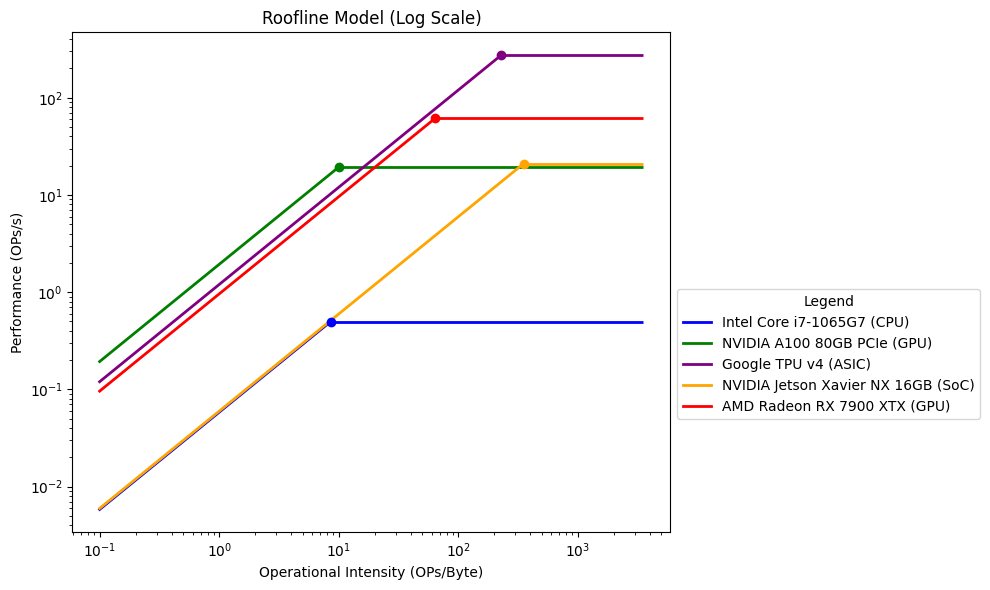

In [10]:
def plot_roofline(chips, model_theoretical_perf=None, model_actual_perf=None, batch_size=None, title=None):
    fig, ax = plt.subplots(figsize=(18, 8) if model_theoretical_perf else (10, 6))
    max_intensity = max(chip['intensity'] for chip in chips) * 10
    ax.set_xlabel('Operational Intensity (OPs/Byte)')
    ax.set_ylabel('Performance (OPs/s)')

    plot_title = 'Roofline Model (Log Scale)'
    if title:
      plot_title += " " + title

    ax.set_title(plot_title)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.grid(False)

    model_names = list(model_theoretical_perf.keys()) if model_theoretical_perf else []
    model_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

    legend_elements = []
    if model_theoretical_perf and model_actual_perf:
      legend_elements = [
          Line2D([0], [0], marker='o', color='w', markerfacecolor='black', label='Theoretical Perf', markersize=10),
          Line2D([0], [0], marker='P', color='w', markerfacecolor='black', label='Actual Perf', markersize=10)
      ]
    elif model_theoretical_perf:
      legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor='black', label='Theoretical', markersize=10)]

    # Plot chips and add to legend
    for chip in chips:
        intensity = chip['intensity']
        performance = chip['performance']
        color = chip['color']
        ax.plot(np.linspace(0.1, intensity, 1000), performance / intensity * np.linspace(0.1, intensity, 1000), color=color, linestyle='-', lw=2)
        ax.scatter(intensity, performance, color=color, zorder=5)
        ax.hlines(performance, xmin=intensity, xmax=max_intensity, colors=color, linestyles='-', lw=2)
        legend_elements.append(Line2D([0], [0], color=color, lw=2, label=chip['label']))

    # Plot theoretical and actual performance data and add model names to legend
    for i, model_name in enumerate(model_names):
        color = model_colors[i]
        if model_name in model_theoretical_perf:
            op_intensity, performance = model_theoretical_perf[model_name]
            ax.scatter(op_intensity, performance, color=color, zorder=5, marker='o', s=80)
        if model_actual_perf and model_name in model_actual_perf:
            actual_flops = model_actual_perf[model_name][batch_size]
            ax.scatter(op_intensity, actual_flops, zorder=5, marker='P', color=color, s=80)
        legend_elements.append(Line2D([0], [0], marker='o', color='w', markerfacecolor=color, label=model_name, markersize=10))

    ax.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1, 0.5), title="Legend")
    plt.tight_layout()
    plt.show()

plot_roofline(chips)

# Analyze 10 DNNs

In [11]:
def compute_flops_and_memory(model, input_tensor):
    # Compute FLOPs
    model.eval()
    flops, params = profile(model, inputs=(input_tensor, ), verbose=False)
    params_memory = params * 4
    params_memory_mb = params_memory / (1024 * 1024)

    # Capture summary output to get estimated total memory size
    f = io.StringIO()
    with redirect_stdout(f):
        summary(model, input_tensor.shape[1:], device="cuda" if next(model.parameters()).is_cuda else "cpu")
    summary_str = f.getvalue()

    # Parse total estimated size
    total_size_match = re.search(r'Estimated Total Size \(MB\): (\d+\.\d+)', summary_str)
    if total_size_match:
        total_size_mb = float(total_size_match.group(1))
    else:
        total_size_mb = None  # In case parsing fails

    return flops, params, total_size_mb

def calculate_operational_intensity(flops, memory_footprint_mb):
  memory_footprint_bytes = memory_footprint_mb * (2**20)  # Convert MB to bytes
  operational_intensity = flops / memory_footprint_bytes  # FLOPs per byte
  return operational_intensity

In [12]:
# Load 10 models to test

resnet50 = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
resnet18 = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
inception = models.inception_v3(weights=models.Inception_V3_Weights.IMAGENET1K_V1)
wide_resnet = models.wide_resnet50_2(weights=models.Wide_ResNet50_2_Weights.IMAGENET1K_V1)
mobilenet = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V1)
squeezenet = models.squeezenet1_0(weights=models.SqueezeNet1_0_Weights.IMAGENET1K_V1)
googlenet = models.googlenet(weights=models.GoogLeNet_Weights.IMAGENET1K_V1)
shufflenet = models.shufflenet_v2_x1_0(weights=models.ShuffleNet_V2_X1_0_Weights.IMAGENET1K_V1)
mnasnet = models.mnasnet1_0(weights=models.MNASNet1_0_Weights.IMAGENET1K_V1)
alexnet_model = models.alexnet(weights=models.AlexNet_Weights.IMAGENET1K_V1)

models_dict = {
    'ResNet50': resnet50,
    'ResNet18': resnet18,
    'Inception': inception,
    'WideResnet': wide_resnet,
    'MobileNet': mobilenet,
    'SqueezeNet': squeezenet,
    'GoogLeNet': googlenet,
    'ShuffleNet': shufflenet,
    'MNASNet': mnasnet,
    'AlexNet': alexnet_model
}

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 133MB/s]
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 85.7MB/s]
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 139MB/s]
Downloading: "https://download.pytorch.org/models/wide_resnet50_2-95faca4d.pth" to /root/.cache/torch/hub/checkpoints/wide_resnet50_2-95faca4d.pth
100%|██████████| 132M/132M [00:01<00:00, 105MB/s]
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 94.5MB/s]
Downloading: "https://download.py

In [13]:
# Obtain flops and memory footprint for all models and calculate
# operational intensity

# bogus input for testing
chart_data = {}
theoretical_roofline_data = {}
all_model_data = {}
input_tensor = torch.randn(1, 3, 224, 224)
for name, model in models_dict.items():
  flops, params, total_memory_mb = compute_flops_and_memory(model, input_tensor)
  operational_intensity = calculate_operational_intensity(flops, total_memory_mb)

  tflops = flops / 1e12
  theoretical_roofline_data[name] = (operational_intensity, tflops)
  chart_data[name] = (tflops, total_memory_mb)
  all_model_data[name] = (tflops, params, total_memory_mb, operational_intensity)

print(theoretical_roofline_data)

{'ResNet50': (10.24971176908377, 0.004133742592), 'ResNet18': (16.112765651051316, 0.001824033792), 'Inception': (13.004751098003464, 0.002856567712), 'WideResnet': (17.476694474660864, 0.011455725568), 'MobileNet': (1.8722838788329537, 0.00032748672), 'SqueezeNet': (8.041480953663447, 0.000819094576), 'GoogLeNet': (12.015994518386567, 0.001511332032), 'ShuffleNet': (2.5460568674794444, 0.000152708792), 'MNASNet': (2.2795604712047703, 0.000336242432), 'AlexNet': (2.8141998453671806, 0.000714206912)}


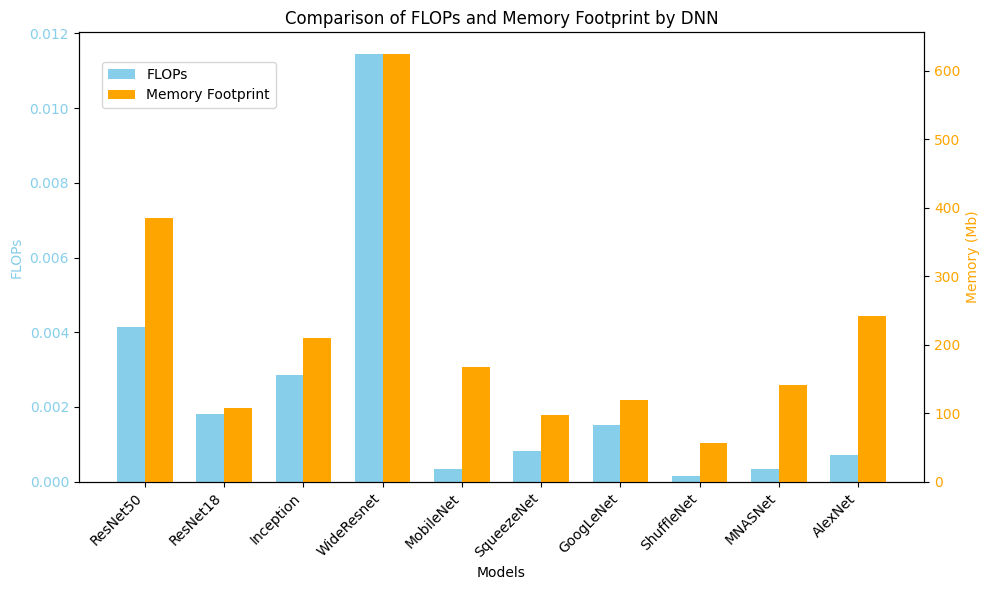

In [14]:
# Compare flops and memory footprint of each DNN
def plot_flops_vs_memory(data):
    names = list(data.keys())
    flops = [item[0] for item in data.values()]
    memory = [item[1] for item in data.values()]

    ind = np.arange(len(data))
    width = 0.35

    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Plot FLOPs
    rects1 = ax1.bar(ind - width/2, flops, width, label='FLOPs', color='skyblue')
    ax1.set_xlabel('Models')
    ax1.set_ylabel('FLOPs', color='skyblue')
    ax1.tick_params(axis='y', labelcolor='skyblue')
    ax1.set_xticks(ind)
    ax1.set_xticklabels(names, rotation=45, ha="right")

    # Create twin axis for Memory
    ax2 = ax1.twinx()
    rects2 = ax2.bar(ind + width/2, memory, width, label='Memory Footprint', color='orange')
    ax2.set_ylabel('Memory (Mb)', color='orange')
    ax2.tick_params(axis='y', labelcolor='orange')

    fig.legend(loc="upper left", bbox_to_anchor=(0.1, 0.9))

    plt.title('Comparison of FLOPs and Memory Footprint by DNN')
    plt.tight_layout()
    plt.show()

plot_flops_vs_memory(chart_data)

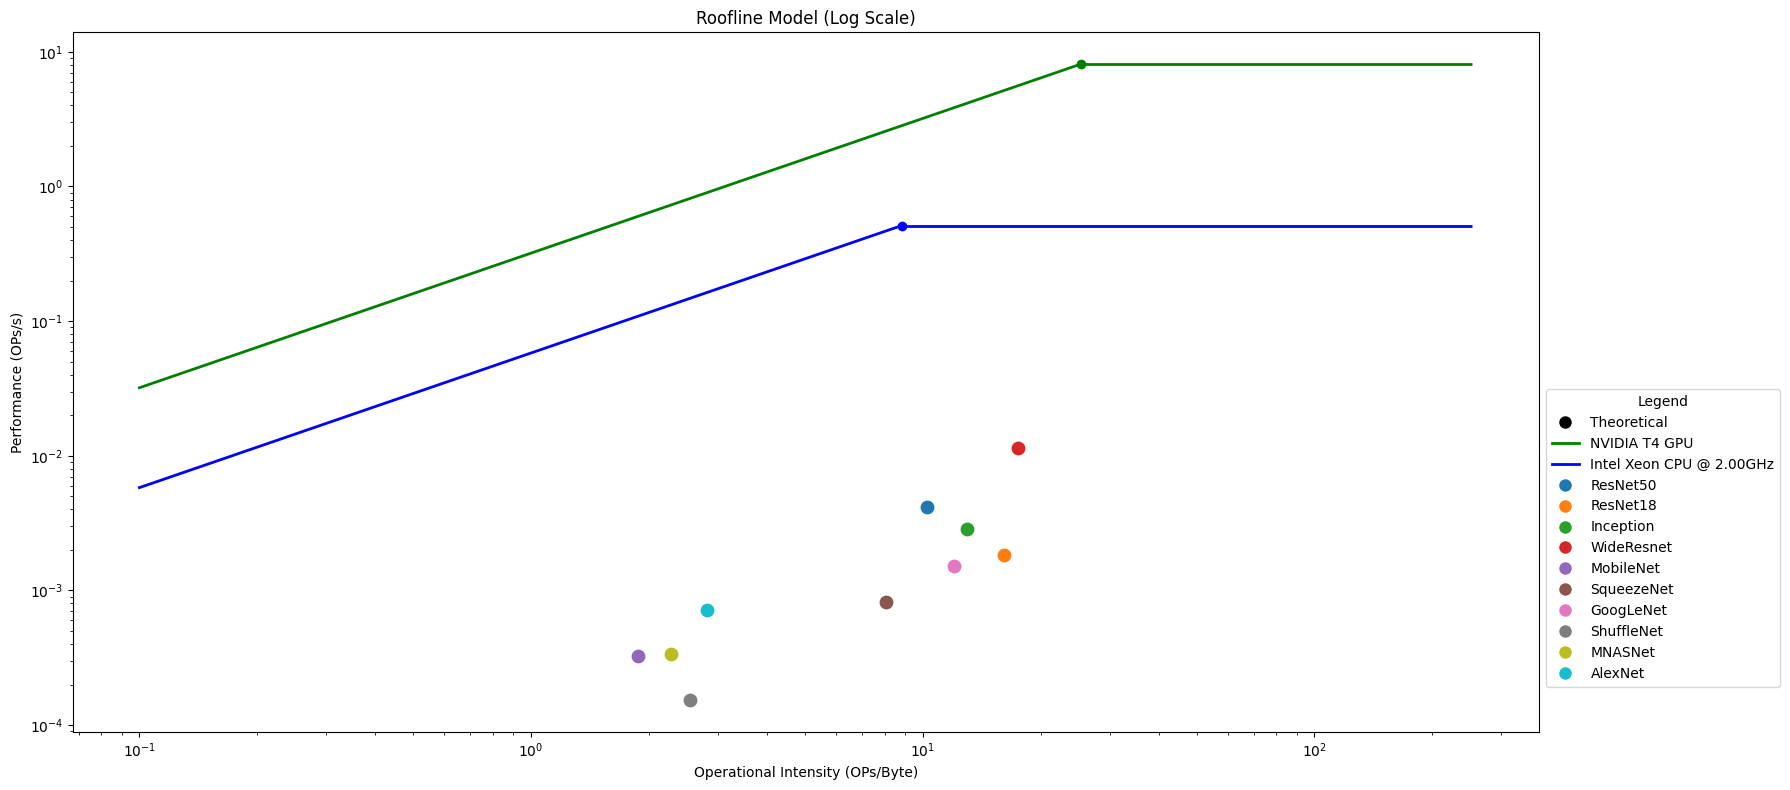

In [15]:
# Overlay operational intensities on GPU and CPU used here
# Using NVIDIA T4 GPU and Intel Xeon CPU @ 2.00GHz
#https://www.nvidia.com/en-us/data-center/tesla-t4/
t4_gpu_Tflops = 8.1 # FP32 8.1
t4_gpu_flops = t4_gpu_Tflops * 1e12
t4_gpu_memory_bs = 320 # GB/s
gpu_operational = get_operation_intensity(t4_gpu_flops, t4_gpu_memory_bs)

cpu_gflops = 512
cpu_Tflops = cpu_gflops / 1000
cput_flops = cpu_gflops * 10**9

cpu_memory_bs = 58
cpu_operational = get_operation_intensity(cput_flops, cpu_memory_bs)

my_chips = [{'intensity': gpu_operational, 'performance': t4_gpu_Tflops, 'color': 'green', 'label': 'NVIDIA T4 GPU'},
            {'intensity': cpu_operational, 'performance': cpu_Tflops, 'color': 'blue', 'label': 'Intel Xeon CPU @ 2.00GHz'}]

plot_roofline(my_chips, theoretical_roofline_data)

# DNN Performance Benchmarking

In [16]:
def measure_inference_time(model, input_tensor, device):
    model = model.to(device)
    model.eval()

    with torch.no_grad():
        for _ in range(2):
            _ = model(input_tensor)
    if device == 'cuda':
        torch.cuda.synchronize()

    num_runs = 10
    start_time = time.perf_counter()
    with torch.no_grad():
        for _ in range(num_runs):
            _ = model(input_tensor)
        if device == 'cuda':
            torch.cuda.synchronize()
    end_time = time.perf_counter()

    avg_inference_time = (end_time - start_time) / num_runs
    return avg_inference_time


def get_all_times(models_dict, batch_sizes, device):
  results = {model_name: {} for model_name in models_dict}
  for model_name, model in models_dict.items():
      print(f"Measuring inference time for {model_name} on {device}...")
      for batch_size in batch_sizes:
          input_tensor = torch.rand(batch_size, 3, 224, 224).to(device)
          avg_time = measure_inference_time(model, input_tensor, device)
          results[model_name][batch_size] = avg_time

          # clear up memory to avoid RAM issues
          del input_tensor
          gc.collect()  # garbage collector
          if device == 'cuda':
              torch.cuda.empty_cache()

      model.to('cpu')
      del model
      gc.collect()
      if device == 'cuda':
          torch.cuda.empty_cache()

  return results

In [17]:
batch_sizes = [1, 64, 256]
# cuda_latencies = get_all_times(models_dict, batch_sizes, 'cuda') # commented out and set below for times sake
# cpu_latencies = get_all_times(models_dict, batch_sizes, 'cpu') # commented out and set below for times sake

cuda_latencies = {'ResNet50': {1: 0.008441355300001873, 64: 0.15926356559999988, 256: 0.6396933802999996}, 'ResNet18': {1: 0.002430101699999909, 64: 0.047845349199999984, 256: 0.19035558449999995}, 'Inception': {1: 0.020266551200001003, 64: 0.11959445089999861, 256: 0.46898960620000024}, 'WideResnet': {1: 0.009284353900000042, 64: 0.2979285447999985, 256: 1.1950785923000011}, 'MobileNet': {1: 0.006022923800000512, 64: 0.05344255150000095, 256: 0.21401898409999945}, 'SqueezeNet': {1: 0.002606535699999313, 64: 0.05650868190000154, 256: 0.23074753720000274}, 'GoogLeNet': {1: 0.01383757140000057, 64: 0.06306515930000103, 256: 0.25159558240000024}, 'ShuffleNet': {1: 0.008599478500002533, 64: 0.02145135469999957, 256: 0.08353189949999944}, 'MNASNet': {1: 0.006657682900001305, 64: 0.05004396580000048, 256: 0.20161012739999934}, 'AlexNet': {1: 0.0014821612999980972, 64: 0.014956520399999817, 256: 0.056653744400000504}}
cpu_latencies = {'ResNet50': {1: 0.11848157919999949, 64: 13.4441595127, 256: 55.955027990299996}, 'ResNet18': {1: 0.05687174710001273, 64: 4.180468525600008, 256: 17.8967427046}, 'Inception': {1: 0.12110681049998676, 64: 8.185155327899997, 256: 37.649602042800005}, 'WideResnet': {1: 0.29251728579999964, 64: 25.23815379710002, 256: 101.44515477999998}, 'MobileNet': {1: 0.027410027000041737, 64: 4.568683945200019, 256: 20.598583616099994}, 'SqueezeNet': {1: 0.046966960500003554, 64: 4.927908495700012, 256: 20.637189617400008}, 'GoogLeNet': {1: 0.09597382729998571, 64: 7.36540965070003, 256: 33.171607733400016}, 'ShuffleNet': {1: 0.01990446460004023, 64: 1.1248325911000392, 256: 7.285878560099991}, 'MNASNet': {1: 0.025451794499986136, 64: 3.5003214251000827, 256: 17.942653209500076}, 'AlexNet': {1: 0.0378955039000175, 64: 1.249439330899986, 256: 5.2286283610999815}}
print("CUDA Results: ", cuda_latencies)
print("CPU Results ", cpu_latencies)

CUDA Results:  {'ResNet50': {1: 0.008441355300001873, 64: 0.15926356559999988, 256: 0.6396933802999996}, 'ResNet18': {1: 0.002430101699999909, 64: 0.047845349199999984, 256: 0.19035558449999995}, 'Inception': {1: 0.020266551200001003, 64: 0.11959445089999861, 256: 0.46898960620000024}, 'WideResnet': {1: 0.009284353900000042, 64: 0.2979285447999985, 256: 1.1950785923000011}, 'MobileNet': {1: 0.006022923800000512, 64: 0.05344255150000095, 256: 0.21401898409999945}, 'SqueezeNet': {1: 0.002606535699999313, 64: 0.05650868190000154, 256: 0.23074753720000274}, 'GoogLeNet': {1: 0.01383757140000057, 64: 0.06306515930000103, 256: 0.25159558240000024}, 'ShuffleNet': {1: 0.008599478500002533, 64: 0.02145135469999957, 256: 0.08353189949999944}, 'MNASNet': {1: 0.006657682900001305, 64: 0.05004396580000048, 256: 0.20161012739999934}, 'AlexNet': {1: 0.0014821612999980972, 64: 0.014956520399999817, 256: 0.056653744400000504}}
CPU Results  {'ResNet50': {1: 0.11848157919999949, 64: 13.4441595127, 256: 55

In [18]:
def plot_performance(gpu_results, cpu_results, all_model_data, batch_sizes, metric='flops'):
    def plot_latency(ax, results, model_data, device, metric):
        batch_sizes = [1, 64, 256]
        for model, latencies in results.items():
            if metric == 'flops':
                metric_value = model_data[model][0]
                ax.set_xlabel('FLOPs')
            elif metric == 'params':
                metric_value = model_data[model][1]
                ax.set_xlabel('Number of Parameters')

            metric_values = [metric_value] * len(batch_sizes)

            color = next(ax._get_lines.prop_cycler)['color']

            latencies = [latencies.get(batch_size, None) for batch_size in batch_sizes]

            ax.scatter(metric_values, latencies, c=color, label=model)

            for i in range(len(batch_sizes) - 1):
                if latencies[i] is not None and latencies[i + 1] is not None:
                    ax.plot([metric_values[i], metric_values[i + 1]], [latencies[i], latencies[i + 1]], c=color)

        ax.set_ylabel('Latency (s)')
        ax.set_title(f'{device} Latency vs {metric.capitalize()}')
        ax.legend()
        ax.grid(True)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    plot_latency(ax1, cpu_results, all_model_data, 'CPU', metric)
    plot_latency(ax2, gpu_results, all_model_data, 'GPU', metric)

    plt.tight_layout()
    plt.show()

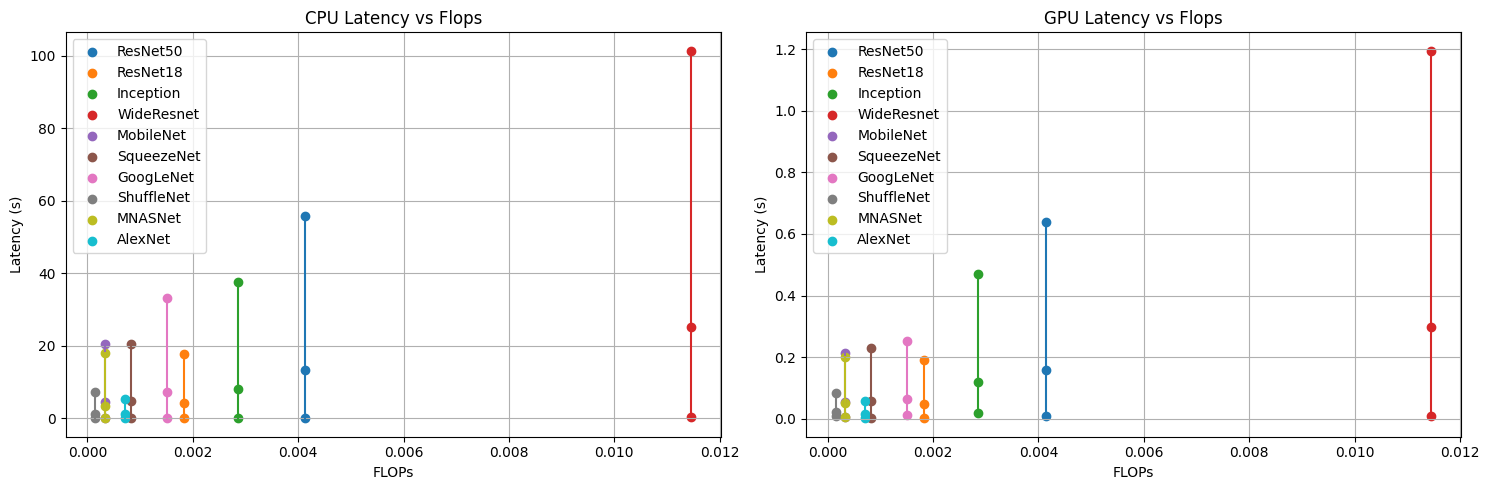

In [19]:
# Plot latency vs flops
plot_performance(cuda_latencies, cpu_latencies, all_model_data, batch_sizes, metric='flops')

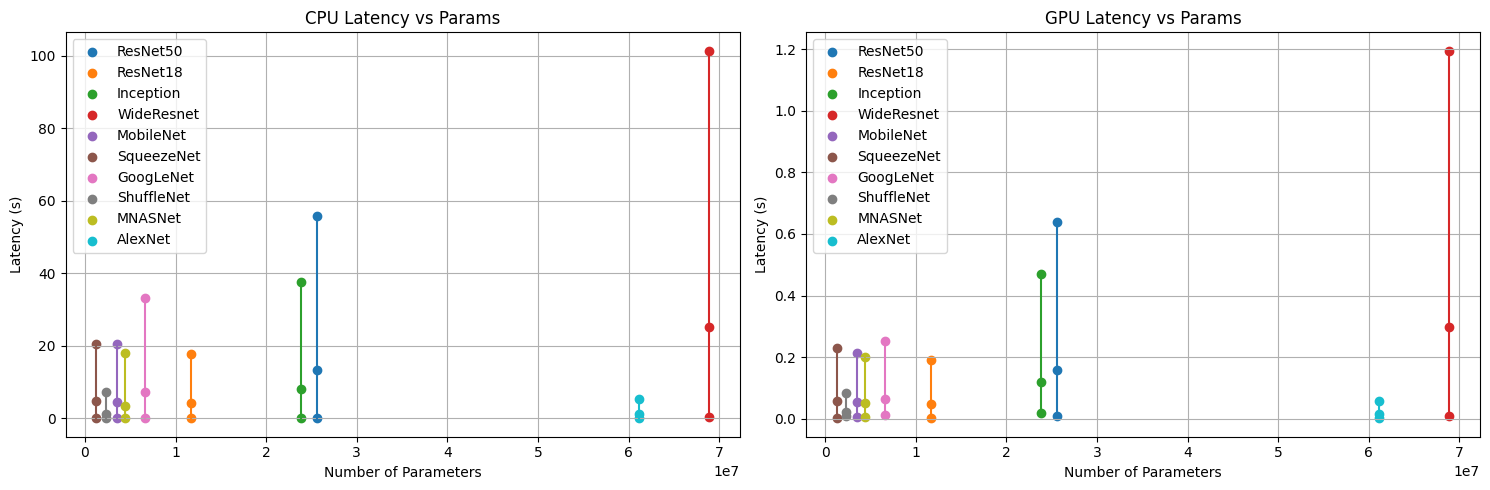

In [20]:
# Plot latency vs params
plot_performance(cuda_latencies, cpu_latencies, all_model_data, batch_sizes, metric='params')

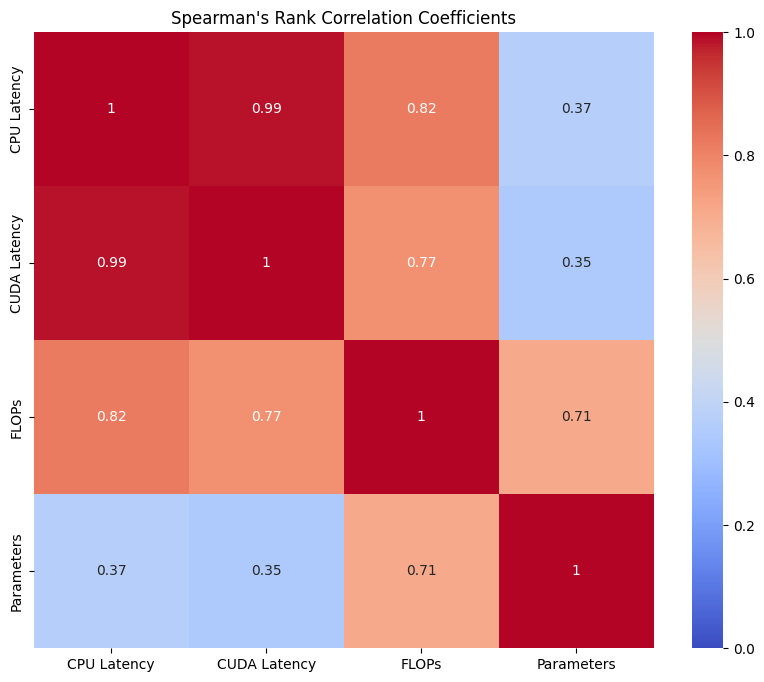

In [21]:
# Visualize Spearmans Corellation
def aggregate_and_correlate(cuda_results, cpu_results, all_model_data):
    flattened_data = []
    for model_name, latencies in cuda_results.items():
        for batch_size, latency in latencies.items():
            flattened_data.append([model_name, batch_size, latency, 'CUDA Latency'])
    for model_name, latencies in cpu_results.items():
        for batch_size, latency in latencies.items():
            flattened_data.append([model_name, batch_size, latency, 'CPU Latency'])

    df = pd.DataFrame(flattened_data, columns=['Model', 'Batch Size', 'Latency', 'Type'])

    avg_latencies = df.groupby(['Model', 'Type'])['Latency'].mean().unstack().reset_index()

    model_data_df = pd.DataFrame(all_model_data.items(), columns=['Model', 'Data'])
    model_data_df[['FLOPs', 'Parameters']] = pd.DataFrame(model_data_df['Data'].tolist(), index=model_data_df.index)[[0, 1]]
    model_data_df.drop(columns=['Data'], inplace=True)

    final_df = pd.merge(avg_latencies, model_data_df, on='Model')

    correlation_matrix = final_df.corr(method='spearman', numeric_only=True)

    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=0, vmax=1)
    plt.title("Spearman's Rank Correlation Coefficients")
    plt.show()

aggregate_and_correlate(cuda_latencies, cpu_latencies, all_model_data)

In [22]:
# Calculate the throughput of the DNNs for both CPU and GPU
# Batch size / average latency per inference
def get_throughputs(model_latencies):
    throughputs = {}
    for name, latencies in model_latencies.items():
        if name not in throughputs:
            throughputs[name] = {}
        for batch_size, latency in latencies.items():
            throughputs[name][batch_size] = batch_size / latency
    return throughputs

cuda_throughputs = get_throughputs(cuda_latencies)
cpu_throughputs = get_throughputs(cpu_latencies)

print(cuda_throughputs)
print(cpu_throughputs)

{'ResNet50': {1: 118.46438924325079, 64: 401.8495991778803, 256: 400.1917291686568}, 'ResNet18': {1: 411.5054114813538, 64: 1337.6430744077425, 256: 1344.851534944067}, 'Inception': {1: 49.34238638490946, 64: 535.1418859183938, 256: 545.8543145001576}, 'WideResnet': {1: 107.70808725850007, 64: 214.81660994572925, 256: 214.2118532198895}, 'MobileNet': {1: 166.03231805787, 64: 1197.547613346995, 256: 1196.1555703880226}, 'SqueezeNet': {1: 383.65098931898905, 64: 1132.569330023574, 256: 1109.4376265351402}, 'GoogLeNet': {1: 72.26701645058603, 64: 1014.8234097935427, 256: 1017.5059417100471}, 'ShuffleNet': {1: 116.2861213037169, 64: 2983.494557572221, 256: 3064.697457286982}, 'MNASNet': {1: 150.2024075072431, 64: 1278.8754643421842, 256: 1269.7774824182807}, 'AlexNet': {1: 674.6903997569522, 64: 4279.070150567961, 256: 4518.677498040142}}
{'ResNet50': {1: 8.44013058191922, 64: 4.760431467622986, 256: 4.575102706487405}, 'ResNet18': {1: 17.583423246017638, 64: 15.309288805329373, 256: 14.30

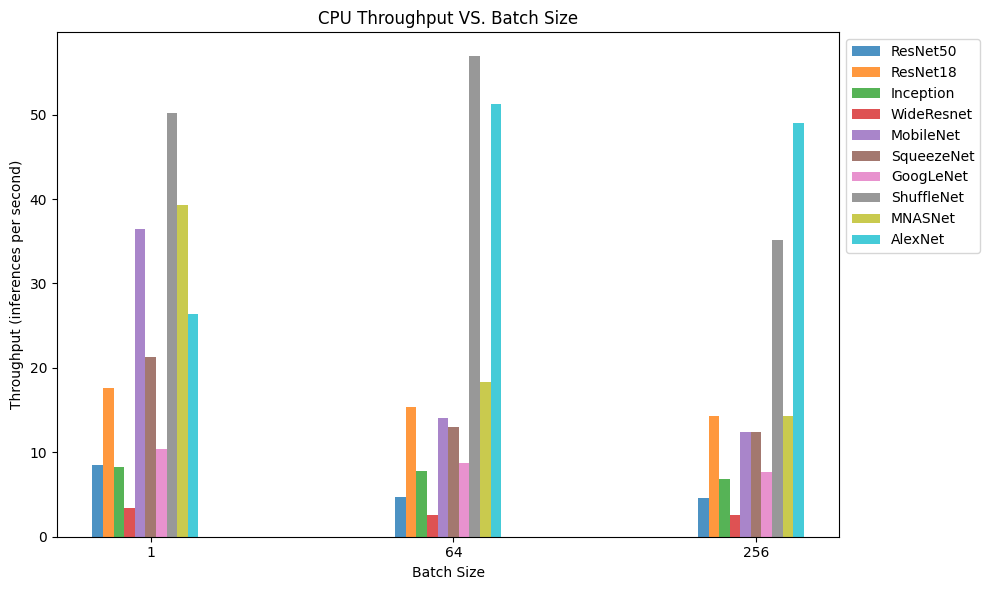

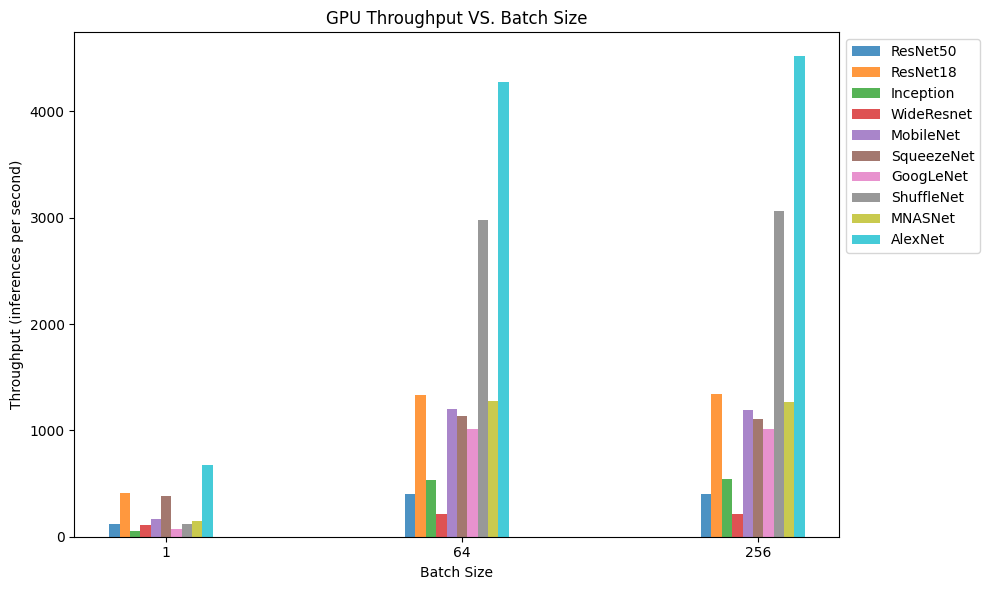

In [23]:
# Plot the througputs for CPU and GPU
def plot_throughputs(throughputs, title):
    models = throughputs.keys()
    batch_sizes = list(throughputs[next(iter(models))].keys())
    n_groups = len(batch_sizes)
    index = np.arange(n_groups)
    bar_width = 0.35 / len(models)
    opacity = 0.8
    plt.figure(figsize=(10, 6))

    for i, model in enumerate(models):
        model_throughputs = [throughputs[model][bs] for bs in batch_sizes]

        plt.bar(index + bar_width*i, model_throughputs, bar_width,
                alpha=opacity, label=model)

    plt.xlabel('Batch Size')
    plt.ylabel('Throughput (inferences per second)')
    plt.title(f'{title} Throughput VS. Batch Size')
    plt.xticks(index + bar_width/2 * len(models), batch_sizes)
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.tight_layout()
    plt.show()

plot_throughputs(cpu_throughputs, 'CPU')
plot_throughputs(cuda_throughputs, 'GPU')

# Hardware Utilization and Peak Performance

ACTUAL CPU:  {'ResNet50': {1: 0.03488932726852123, 64: 0.00030747497365640953, 256: 7.387615984602133e-05}, 'ResNet18': {1: 0.0320727581797745, 64: 0.00043632281425637636, 256: 0.00010191987570627411}, 'Inception': {1: 0.023587176478405504, 64: 0.0003489937084349611, 256: 7.587245434235025e-05}, 'WideResnet': {1: 0.03916255935668884, 64: 0.0004539050542324659, 256: 0.00011292531016235886}, 'MobileNet': {1: 0.011947697826036484, 64: 7.16807561932723e-05, 256: 1.5898506717910164e-05}, 'SqueezeNet': {1: 0.017439803795690333, 64: 0.0001662154597056184, 256: 3.9690219026208385e-05}, 'GoogLeNet': {1: 0.015747335232094314, 64: 0.00020519320766583006, 256: 4.556101242202565e-05}, 'ShuffleNet': {1: 0.007672087396899455, 64: 0.000135761350807463, 256: 2.095955768962257e-05}, 'MNASNet': {1: 0.01321095186432466, 64: 9.606044450343186e-05, 256: 1.873983897888469e-05}, 'AlexNet': {1: 0.018846745352280966, 64: 0.0005716219221989341, 256: 0.00013659546303071874}}
ACTUAL GPU:  {'ResNet50': {1: 0.489701

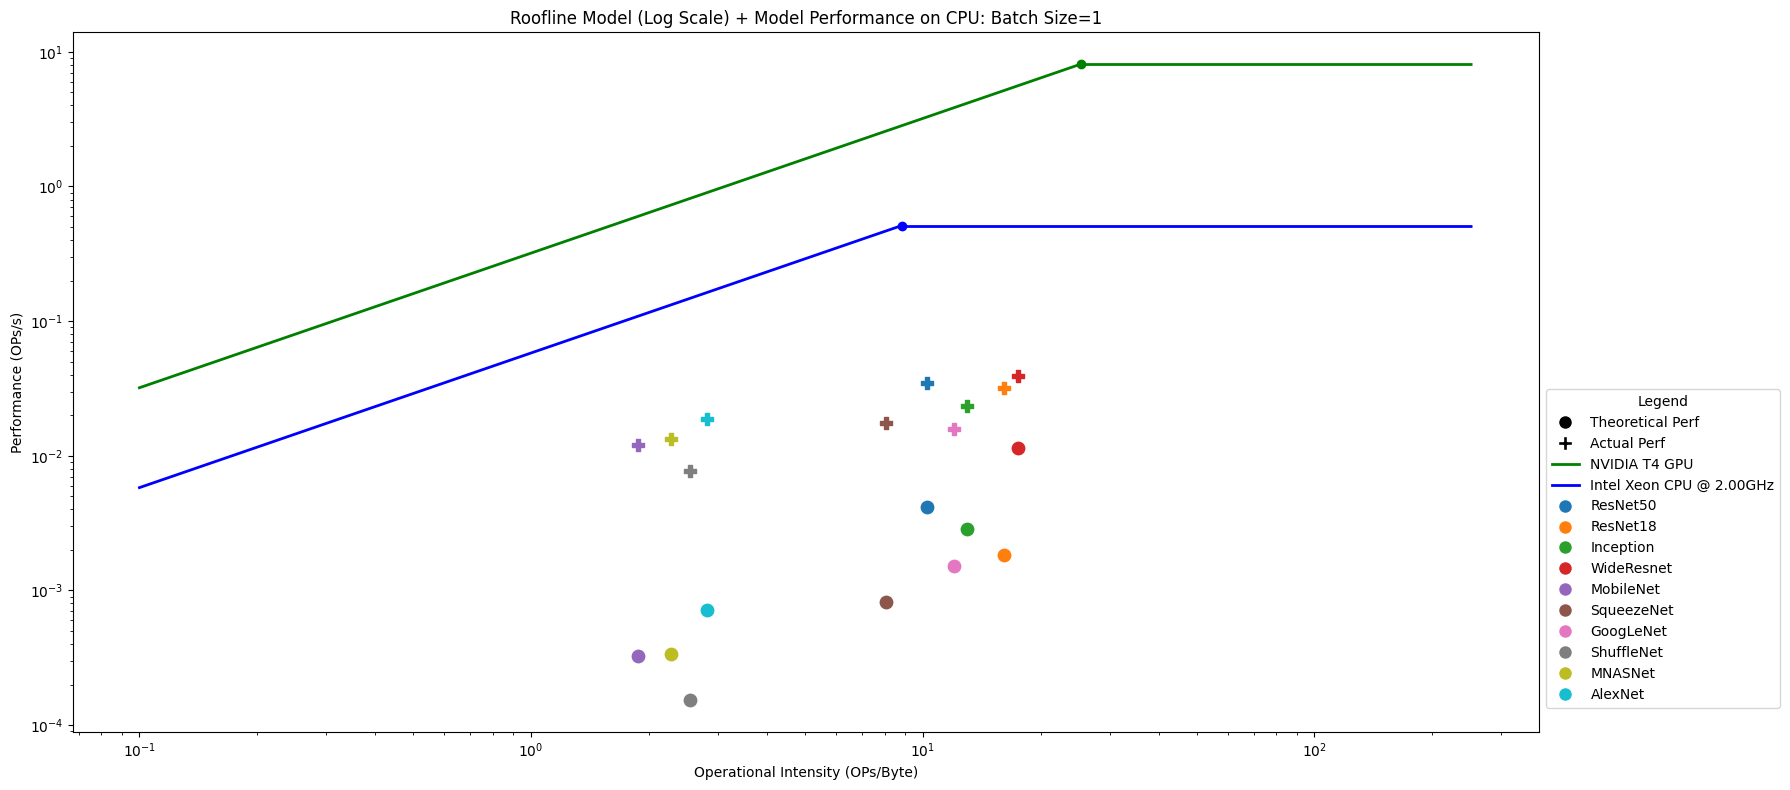

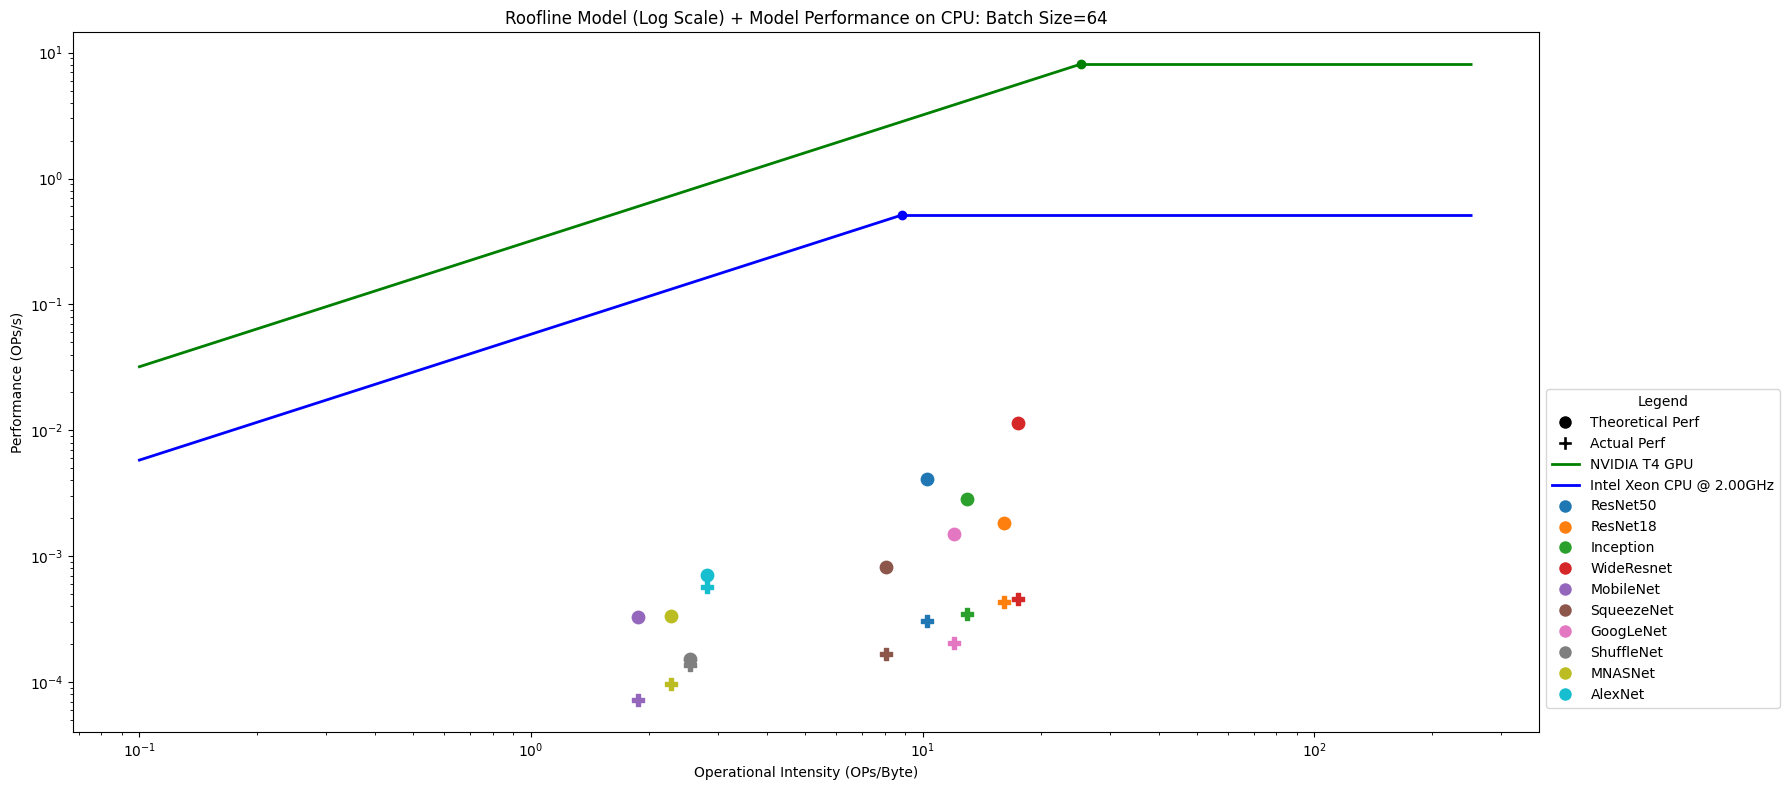

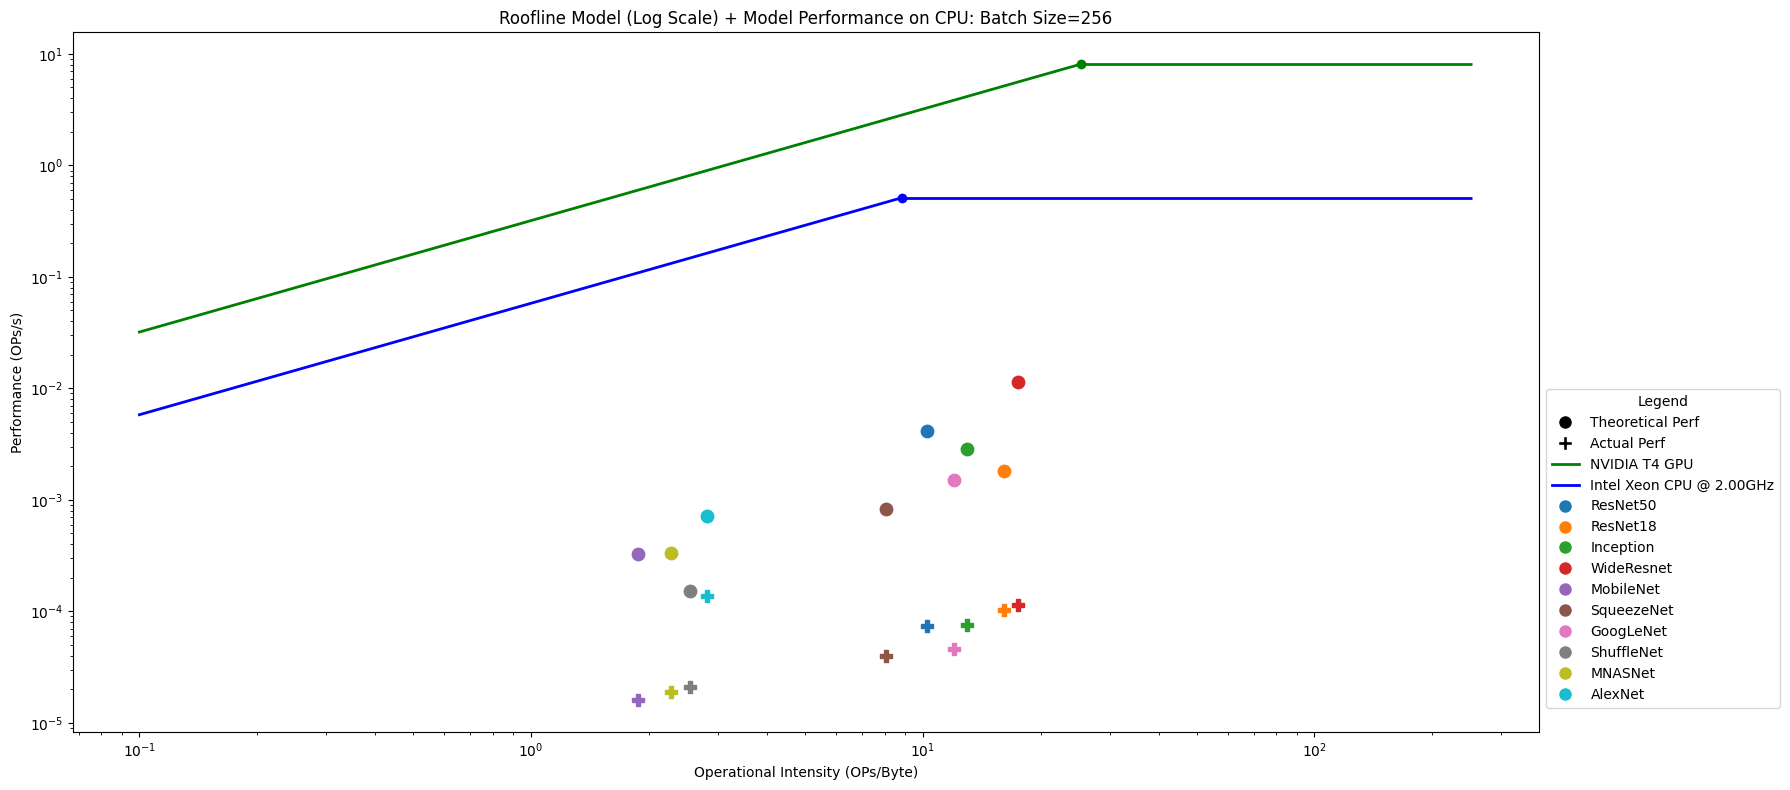

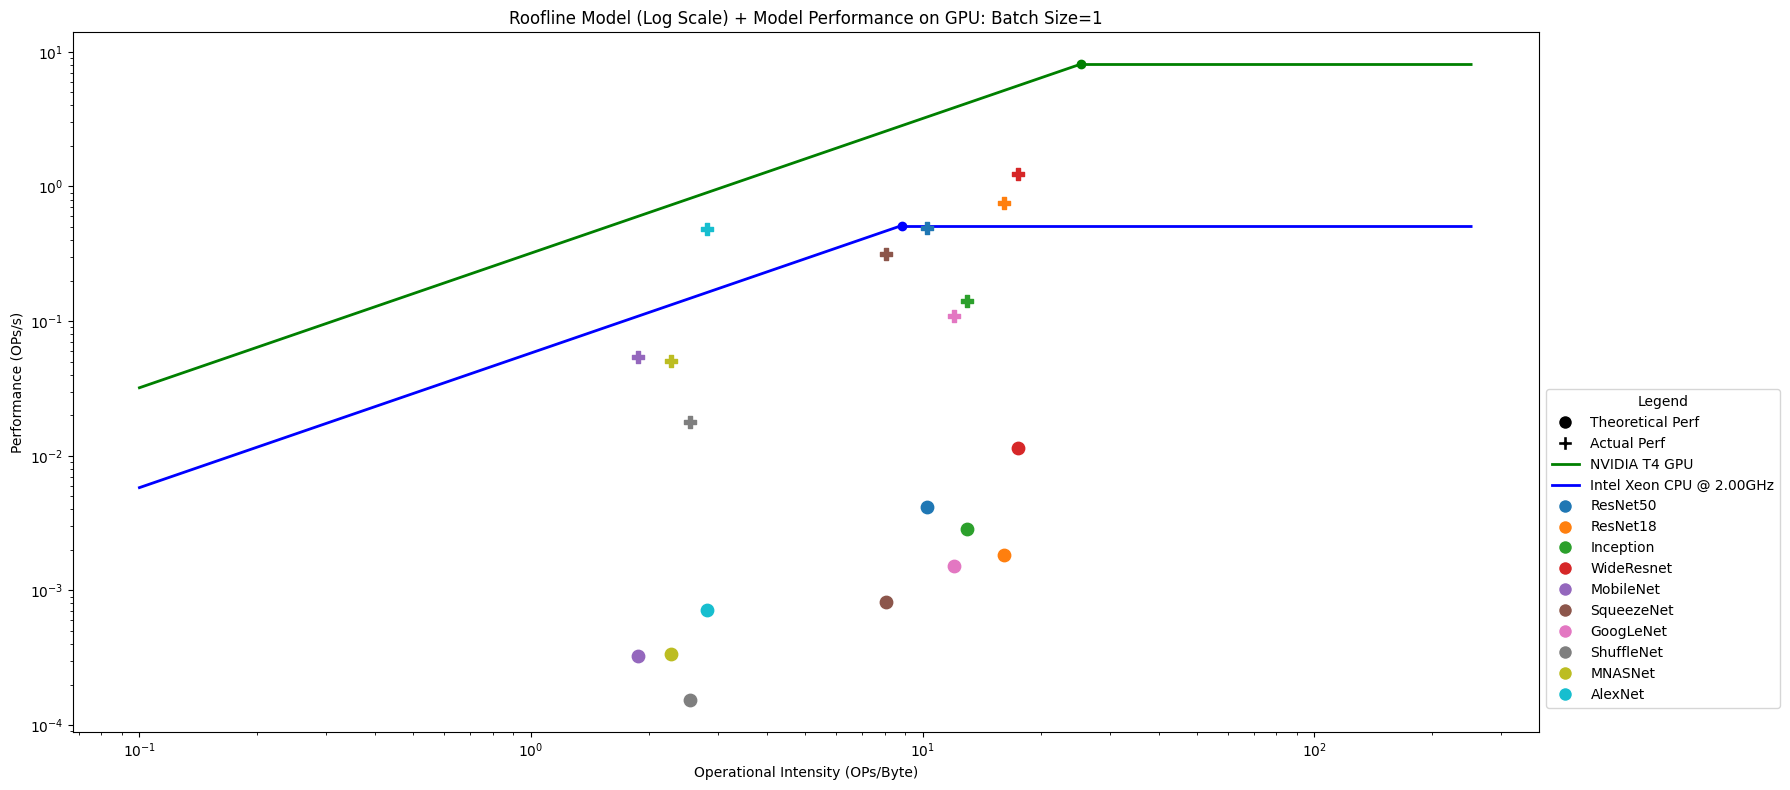

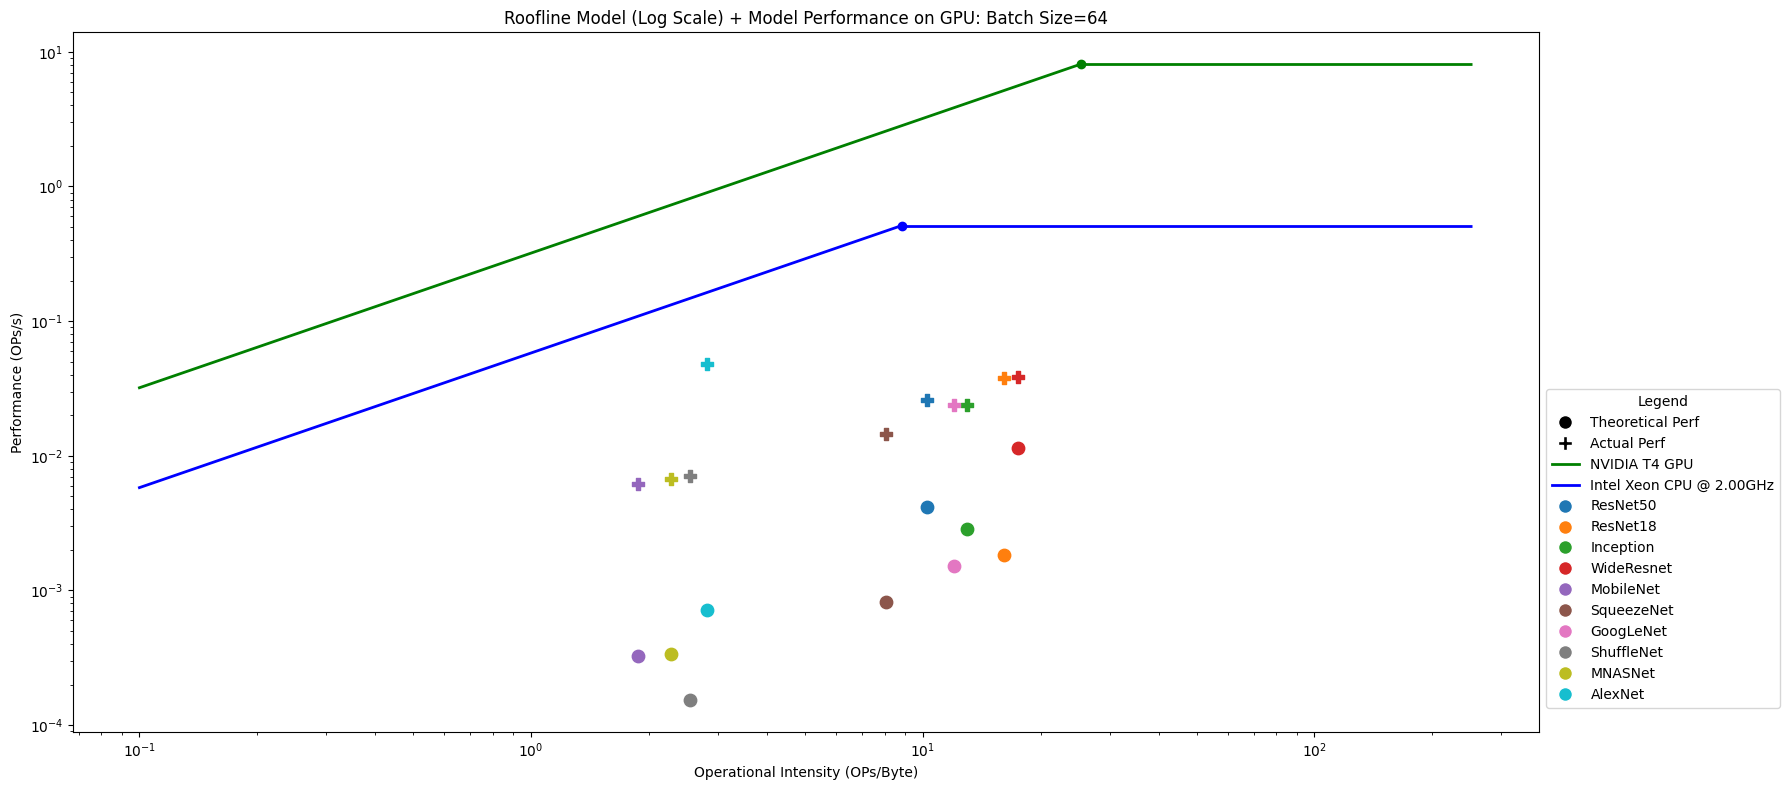

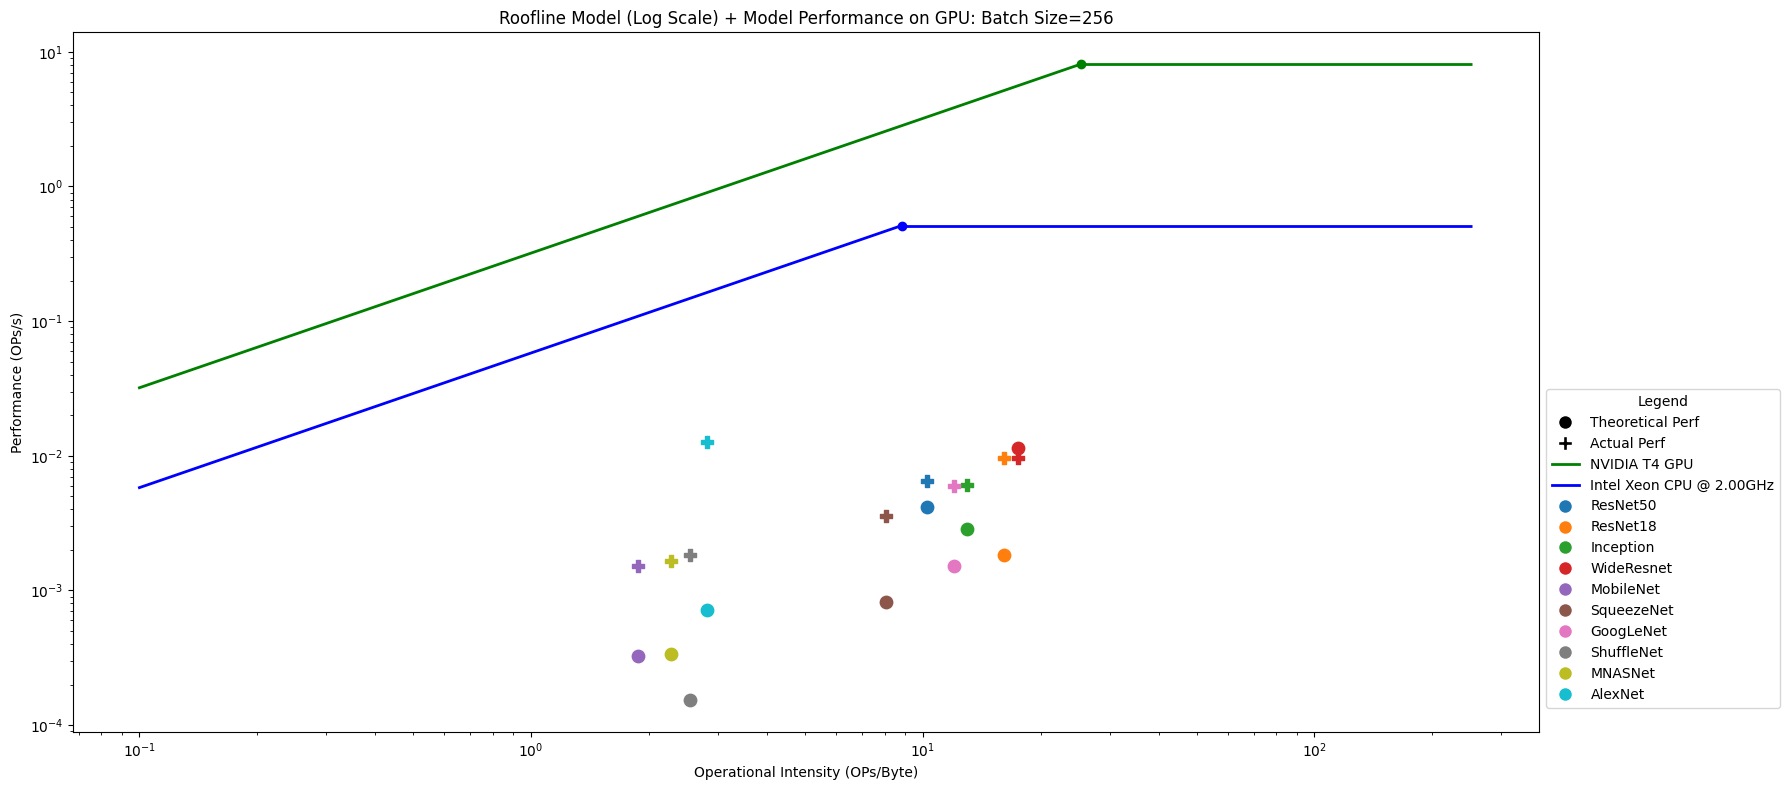

In [24]:
# Plot actual performance on current CPU and GPU Roofline plot
# Flops / Latency
def get_actual_perf(latencies, roofline_data):
  actual_perf = copy.deepcopy(latencies)
  for name, batches_dict in actual_perf.items():
    for batch, latency in batches_dict.items():
      actual_perf[name][batch] = roofline_data[name][1] / latency
  return actual_perf

cpu_actual_perf = get_actual_perf(cpu_latencies, theoretical_roofline_data)
cuda_actual_perf = get_actual_perf(cuda_latencies, theoretical_roofline_data)
print("ACTUAL CPU: ",cpu_actual_perf)
print("ACTUAL GPU: ",cuda_actual_perf)

for batch in batch_sizes:
  plot_roofline(my_chips, theoretical_roofline_data, cpu_actual_perf, batch, "+ Model Performance on CPU: Batch Size=" + str(batch))

for batch in batch_sizes:
  plot_roofline(my_chips, theoretical_roofline_data, cuda_actual_perf, batch, "+ Model Performance on GPU: Batch Size=" + str(batch))

# Inference Vs. Training

In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

WideResnet = models.wide_resnet50_2(weights=models.Wide_ResNet50_2_Weights.IMAGENET1K_V1)
AlexNet = models.alexnet(weights=models.AlexNet_Weights.IMAGENET1K_V1)

models_list = [('WideResnet', WideResnet), ('AlexNet', AlexNet)]

batch_size = 32
input_size = (batch_size, 3, 224, 224)
dummy_input = torch.randn(input_size).to(device)
target = torch.empty(batch_size, dtype=torch.long).random_(1000).to(device)

def measure_time(model, input_tensor, target):
    start_time = time.time()
    output = model(input_tensor)
    forward_time = time.time() - start_time

    loss_fn = torch.nn.CrossEntropyLoss()
    loss = loss_fn(output, target)
    start_time = time.time()
    loss.backward()
    backward_time = time.time() - start_time

    return forward_time, backward_time

def measure_flops(model, input_tensor):
    model.eval()

    forward_flops, _ = profile(model, inputs=(input_tensor, ), verbose=False)

    # Estimating backward pass FLOPs
    # assumes the backward pass is about 2x the forward pass plus additional 20% for weight gradient calculations.
    backward_flops = forward_flops * 2 * 1.2
    return forward_flops, backward_flops

for name, model in models_list:
    model.eval()
    model.train()
    forward_time, backward_time = measure_time(model, dummy_input, target)
    forward_flops, backward_flops = measure_flops(model, dummy_input)
    time_ratio = forward_time / backward_time
    flops_ratio = forward_flops / backward_flops
    print(f"{name} Time Ratio (Forward:Backward): {time_ratio:.2f}")
    print(f"{name} FLOPs Ratio (Forward:Backward): {flops_ratio:.2f}")

    model.zero_grad()

WideResnet Time Ratio (Forward:Backward): 0.53
WideResnet FLOPs Ratio (Forward:Backward): 0.42
AlexNet Time Ratio (Forward:Backward): 0.49
AlexNet FLOPs Ratio (Forward:Backward): 0.42


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Wide_ResNet50_2_Weights.IMAGENET1K_V1`. You can also use `weights=Wide_ResNet50_2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-

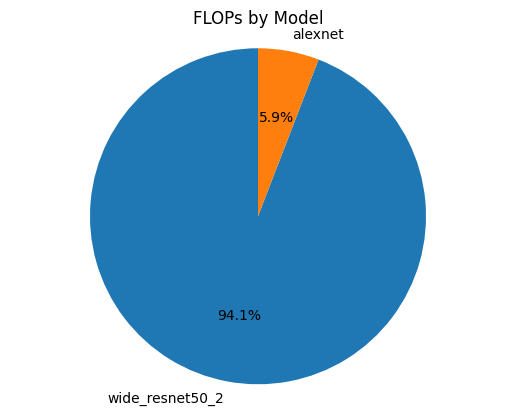

In [26]:
model_names = ['wide_resnet50_2', 'alexnet']
models_dict = {
    'wide_resnet50_2': models.wide_resnet50_2(pretrained=True).to(device),
    'alexnet': models.alexnet(pretrained=True).to(device),
}

input_size = (1, 3, 224, 224)
dummy_input = torch.randn(input_size).to(device)

def calculate_flops_and_params(model, input):
    model.eval()
    flops, params = profile(model, inputs=(input, ), verbose=False)
    return flops, params

data = defaultdict(lambda: defaultdict(list))
for name, model in models_dict.items():
    flops, _ = calculate_flops_and_params(model, dummy_input)
    data[name]['FLOPs'] = flops

def plot_data(data, title="FLOPs by Model"):
    labels = list(data.keys())
    sizes = [data[name]['FLOPs'] for name in labels]

    fig, ax = plt.subplots()
    ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
    ax.axis('equal')
    plt.title(title)
    plt.show()

plot_data(data)